In [77]:
import pandas as pd
import numpy as np
from scipy import stats
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [149]:
# Load the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()  # Replace with your dataset file name
df = df.drop(columns=['Close'])
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format
df.set_index('Date', inplace=True)  # Set 'Date' as the index

# Features and target
features = df.columns.drop(['Adj Close'])  # Exclude the target variable and redundant columns
target = 'Adj Close'

X = df[features]
y = df[target]

# Normalize the features for better model performance
# Select only numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Handle missing values
X_numeric = X_numeric.dropna()

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns, index=X_numeric.index)

# Number of days to predict
future_steps = 14

# Prepare multi-step target data
y_multi = []

for i in range(len(y) - future_steps):
    y_multi.append(y.iloc[i + 1: i + 1 + future_steps].values)

y_multi = np.array(y_multi)

# Truncate X to match the length of y_multi
X_scaled_df = X_scaled_df.iloc[:-future_steps]

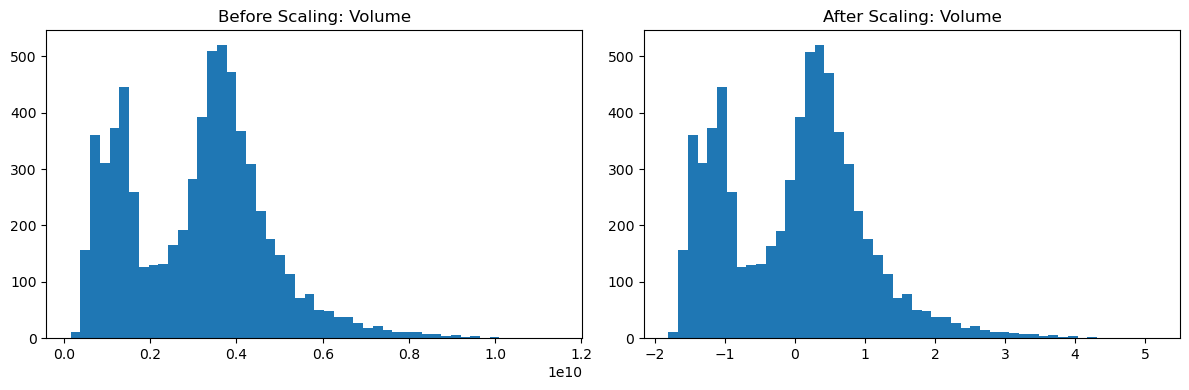

In [120]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(X['Volume'], bins=50)
plt.title('Before Scaling: Volume')

plt.subplot(1, 2, 2)
plt.hist(X_scaled_df['Volume'], bins=50)
plt.title('After Scaling: Volume')

plt.tight_layout()
plt.show()

In [131]:
def forward_validation(df, initial_train_size, step_size, model_params):
    predictions = []
    actuals = []
    dates = []
    n_splits = (len(df) - initial_train_size) // step_size

    # Train 14 separate models for 14 future steps
    models = [xgb.XGBRegressor(**model_params) for _ in range(future_steps)]

    for i in range(n_splits):
        train_start = 0
        train_end = initial_train_size + i * step_size
        test_start = train_end
        test_end = test_start + step_size

        # Extract train and test sets for current fold
        X_train, y_train = X_scaled_df.iloc[train_start:train_end], y_multi[train_start:train_end]
        X_test, y_test = X_scaled_df.iloc[test_start:test_end], y_multi[test_start:test_end]

        dates.extend(df.index[test_start:test_end])

        fold_preds = []

        # Train and predict for each future step
        for step in range(future_steps):
            model = models[step]
            model.fit(X_train, y_train[:, step])
            preds = model.predict(X_test)
            fold_preds.append(preds)

        # Append predictions for the entire fold (14 days)
        fold_preds = np.array(fold_preds).T
        predictions.extend(fold_preds)
        actuals.extend(y_test)

    return np.array(predictions), np.array(actuals), dates, models


In [150]:
# Define forward validation parameters
initial_train_size = 800  # Initial training set size
step_size = 100  # Step size for moving train-test splits
model_params = {"n_estimators": 100, "learning_rate": 0.05, "max_depth": 5, "random_state": 42}

# Perform forward validation
predictions, actuals, dates, models = forward_validation(df, initial_train_size, step_size, model_params)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Model Performance Metrics for Step 1:
R-squared Score: 0.9901
Root Mean Square Error (RMSE): 105.3584
Mean Absolute Error: 57.6438

Model Performance Metrics for Step 2:
R-squared Score: 0.9874
Root Mean Square Error (RMSE): 118.6854
Mean Absolute Error: 67.9466

Model Performance Metrics for Step 3:
R-squared Score: 0.9849
Root Mean Square Error (RMSE): 130.0219
Mean Absolute Error: 75.3808

Model Performance Metrics for Step 4:
R-squared Score: 0.9825
Root Mean Square Error (RMSE): 140.1247
Mean Absolute Error: 82.3623

Model Performance Metrics for Step 5:
R-squared Score: 0.9812
Root Mean Square Error (RMSE): 145.1474
Mean Absolute Error: 87.7567

Model Performance Metrics for Step 6:
R-squared Score: 0.9782
Root Mean Square Error (RMSE): 156.2916
Mean Absolute Error: 93.6694

Model Performance Metrics for Step 7:
R-squared Score: 0.9778
Root Mean Square Error (RMSE): 157.8342
Mean Absolute Error: 96.2766

Model Performance Metrics for Step 8:
R-squared Score: 0.9749
Root Mean Squ

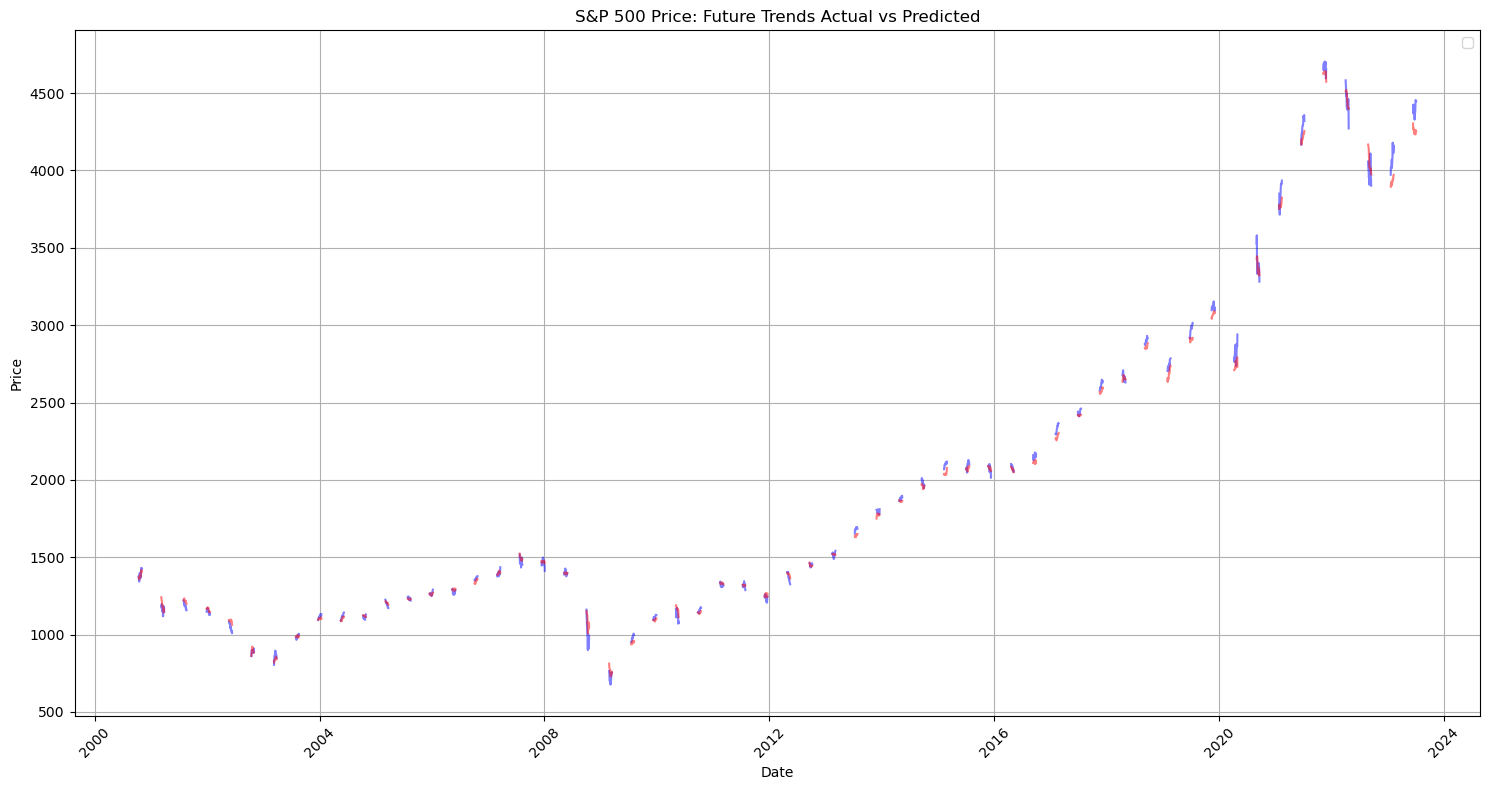

In [151]:
# Calculate performance metrics for each future step
for step in range(future_steps):
    step_preds = predictions[:, step]
    step_actuals = actuals[:, step]

    test_rmse = mean_squared_error(step_actuals, step_preds, squared=False)
    test_r2 = r2_score(step_actuals, step_preds)
    test_mae = mean_absolute_error(step_actuals, step_preds)

    print(f"\nModel Performance Metrics for Step {step + 1}:")
    print(f"R-squared Score: {test_r2:.4f}")
    print(f"Root Mean Square Error (RMSE): {test_rmse:.4f}")
    print(f"Mean Absolute Error: {test_mae:.4f}")

# Mean Prediction Accuracy for all steps
mean_prediction_accuracy = 100 * (1 - np.mean(np.abs(predictions - actuals)) / np.mean(actuals))
print(f"\nMean Prediction Accuracy over {future_steps} Steps: {mean_prediction_accuracy:.2f}%")

plt.figure(figsize=(15, 8))
for i in range(0, len(dates), step_size):
    plt.plot(dates[i:i+future_steps], actuals[i], color='blue', alpha=0.5)
    plt.plot(dates[i:i+future_steps], predictions[i], color='red', alpha=0.5)

plt.title('S&P 500 Price: Future Trends Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



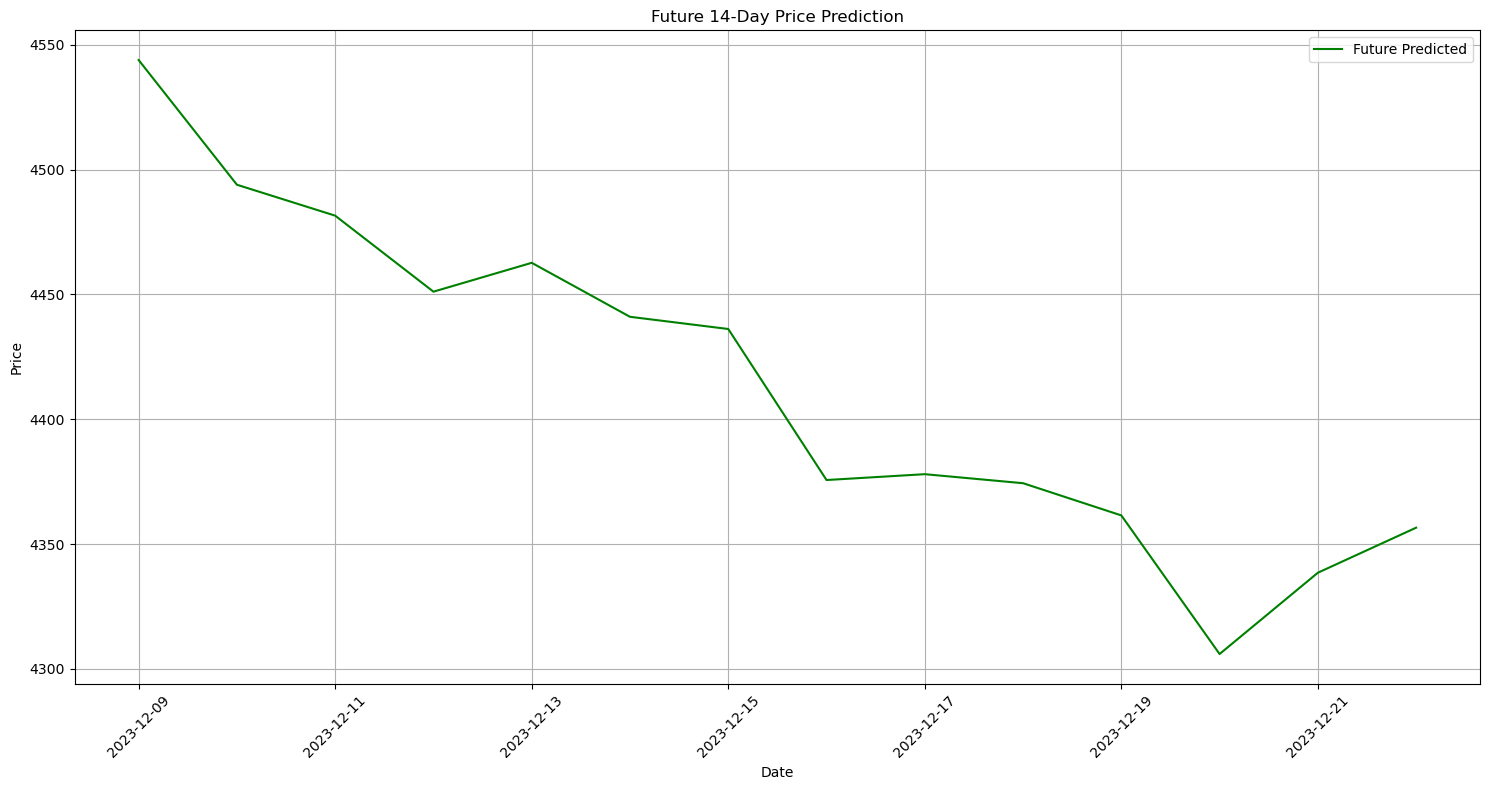

In [157]:
# Extract the latest available feature data as input for the future prediction
latest_X = X_scaled_df.iloc[[-1]]  # Get the last 250 rows as input

# Initialize an empty list to store future predictions
future_predictions = []

# Predict the next 7 days using the trained models
for step in range(future_steps):
    model = models[step]  # Use the trained model for each future step
    pred = model.predict(latest_X)
    future_predictions.append(pred[0])

    # Update `latest_X` with the new prediction if necessary
    # If your feature set involves past values (e.g., a moving window), you need to update `latest_X` accordingly.
    # For simplicity, here we assume `latest_X` stays the same; in practice, you might add the prediction back into the feature set.

# Convert predictions to a DataFrame for easier visualization
future_dates = pd.date_range(start=X_scaled_df.index[-1] + pd.Timedelta(days=1), periods=future_steps)
future_predictions_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted_Adj_Close'])

# Plot the future trend
plt.figure(figsize=(15, 8))
plt.plot(future_predictions_df.index, future_predictions_df['Predicted_Adj_Close'], label='Future Predicted', color='green')
plt.title('Future 14-Day Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
